In [13]:
import numpy as np
from shapely.geometry import Polygon, LineString, MultiLineString, MultiPolygon
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr

In [2]:
class Weights_Mask:
    """
    Class for masking a shapefile with a given grid. 
    It calculates the areal weight of each grid relatively to the domain, where the sum is 1.
    And/ or calculates the area percentil: Area of polygon covering each gridcell.
    """
    def __init__(self, 
                 xarray, 
                 shapefile_region, 
                 longitude, 
                 latitude):
        """
        Init function creates grided polygons. It calcualtes the intersection/area between 
        shapefile and grid. 
        
        Parameters
        ----------
        xarray : Provided file/ Netcdf/ Xarray to extract the grid from.
        shapegile_region : Provided region from shapefile (e.g. ".shp") to be masked. Shapefile must be already projected if necessary.
        longitude : Name for longitude coordinate, longitude coordinate, maximum and minimum values 
                    "['rlon',xarray.rlon,max(xarray.rlon.values),min(xarray.rlon.values)]"
        latitude : Name for latitude coordinate, latitude coordinate, maximum and minimum values 
                    "['rlat',xarray.rlat,max(xarray.rlat.values),min(xarray.rlat.values)]"
                    
        Returns
        -------
        poly_pol : Numpy array with dimension (lon,lat) containing the area between shapefile and grided polygons.

        """
        self.xarray=xarray
        self.shapefile_region=shapefile_region
        self.lon_name, self.lon= lon_name,lon=longitude # , self.lon_max, self.lon_min = lon_name,lon,lon_max,lon_min = longitude
        self.lat_name, self.lat=lat_name,lat=latitude #, self.lat_max, self.lat_min = lat_name,lat,lat_max,lat_min = latitude
        
        
        #Creating grid as polygons to intersect with shapefile
        grid_cells = []
        for i in range(len(self.lon)-2):
            for j in range(len(self.lat)-2):
            # bounds
                cell_size_x=np.float64(self.lon[i+1])-np.float64(self.lon[i])
                cell_size_y=np.float64(self.lat[j+1])-np.float64(self.lat[j])

                x0=np.float64(self.lon[i])+cell_size_x/2.
                y0=np.float64(self.lat[j])+cell_size_y/2.
                
                cell_size_x=np.float64(self.lon[i+2])-np.float64(self.lon[i+1])
                cell_size_y=np.float64(self.lat[j+2])-np.float64(self.lat[j+1])
                
                x1 = np.float64(self.lon[i+1])+cell_size_x/2.
                y1 = np.float64(self.lat[j+1])+cell_size_y/2.
                grid_cells.append(Polygon([[x0, y0],[x1,y0],[x1,y1], [x0, y1],[x0,y0]]))

        #selecting the geometry from the given shapefile
        polygons_to = shapefile_region.geometry.iloc[0]

        #Calculating the areal weights as intersection between shapefile and grided polygon
        areas=[]
        for r in grid_cells:
            intersect = polygons_to.intersection(r)
            areas.append(intersect.area)
        poly_area=areas

        #Truning result in 2D array with right dimensions
        pol=np.reshape(poly_area, (len(lon)-2, len(lat)-2))
        
        self.poly_pol=np.nan_to_num(pol)

        
    def areal_weights(self):
        """
        areal_weights calculates the areal weight of each grid relatively to the domain, where the sum is 1.
         
        Returns
        -------
        arr1 : Xarray.DataArray with dimensions (lon,lat). Variable name is "weights".

        """
        arr1 = xr.DataArray(self.poly_pol.T/(sum(sum(self.poly_pol.T))), [(self.lat_name, self.lat[1:-1]),(self.lon_name, self.lon[1:-1])], name='weights')
        return(arr1)


In [3]:
class Rotated_Pole(Weights_Mask):
    """
    The class projects a provided shapefile in the coordinate system of a provided xarray or values defined by the user.
    The projection for this class is a projected pole grid. 
    To be specified are pole_longitude, pole_latitude, central_rotated_longitude and globe.
    The projection is equivalent to locating the pole in predefined coordinates and rotating the coordinate system using the new pole.

    """
    def __init__(
        self, 
        xarray, 
        shapefile_region,
        pole_longitude=0., 
        pole_latitude=None,
        central_rotated_longitude=None, 
        globe='WGS84'):
        
        """
        Init function projects the provided shapefile in the coordinate system of the provided xarray.
        Finially calls the class Weights_Mask and automatically calculates the area of the intersection between shapefile and grided polygons.
        
        Parameters
        ----------
        xarray : Provided file/ Netcdf/ Xarray to extract the grid from.
        shapegile_region : Provided region from shapefile (e.g. ".shp") to be masked. Shapefile must be already projected if necessary.
        pole_longitude : Longitude of pole position (unrotated degrees). Default is 0.
        pole_latitude : Latitude of new pole position. Default is extracted form xarray.
        central_rotated_longitude : Longitude of new pole position. Default extracted form xarray.
        globe: Default is "WGS84".
        
        """
        
        self.xarray=xarray
        self.shapefile_region=shapefile_region
        
        try:
            self.crs=xarray.crs
        
        except:
            #Projection values
            self.pole_longitude = pole_longitude or 0.0
            self.pole_latitude = pole_latitude or xarray.rotated_pole.grid_north_pole_latitude or xarray.rotated_latitude_longitude.grid_north_pole_latitude
            self.central_rotated_longitude = central_rotated_longitude or xarray.rotated_pole.grid_north_pole_longitude or xarray.rotated_latitude_longitude.grid_north_pole_longitude
            self.globe = globe or 'WGS84'

            #if self.central_rotated_longitude==None:
            #    raise ValueError("specify central_rotated_longitude")
            #if self.pole_latitude==None:
            #    raise ValueError("specify pole_latitude")
            #else:

            self.crs="+proj=ob_tran +o_proj=longlat +o_lon_p={} +o_lat_p={} +lon_0={} +to_meter={} +ellps={}".format(self.pole_longitude,self.pole_latitude, 180.+self.central_rotated_longitude, math.radians(1), self.globe )      

        self.proj_shp_region=proj_shp_region=self.shapefile_region.to_crs(self.crs)

        longitude = ['rlon',xarray.rlon]
        latitude = ['rlat',xarray.rlat]
        
        super().__init__(xarray,proj_shp_region,longitude,latitude)


In [4]:
class Default(Weights_Mask):
    """
    The class provides the class Weights_mask with the information needed to proceed with the calculation fo the maks and weights.
    This class is the default option in which no coordinate projection is necessary. 
    Shapefile and Xarray have already same coordinate systems in a (lon/lat)-grid.
    
    """
    def __init__(
        self, 
        xarray, 
        shapefile_region):
        
        """
        Init function extracts the necessary information to be provided to the class Weights_mask.
        These are: xarray, shapefile, region, longitude and latitude.
        Finially calls the class Weights_Mask and automatically calculates the area of the intersection between shapefile and grided polygons.
        
        Parameters
        ----------
        xarray : Provided file/ Netcdf/ Xarray to extract the grid from.
        shapegile_region : Provided region from shapefile (e.g. ".shp") to be masked. Shapefile must be already projected if necessary.
        
        """
        
        self.xarray=xarray
        self.shapefile_region=shapefile_region   
        
        longitude = ['lon',xarray.lon]
        latitude = ['lat',xarray.lat]

        super().__init__(xarray,shapefile_region,longitude,latitude)

In [5]:
from mpl_toolkits.basemap import Basemap
import shapely
import re
import os
import json
import utm
from shapely.geometry import asLineString
from shapely.ops import transform
from shapely.ops import unary_union

def susanne(polygon, lat, lon, projection):
    glats = np.squeeze(lat)
    glons = np.squeeze(lon)
    latlon=np.zeros((len(glats), 2))
    for uu in range(0, len(glats)):
        latlon[uu,:] = [glons[uu], glats[uu]]
    lon_center, lat_center = np.mean(latlon,axis=0)
    glons, glats = np.meshgrid(glons, glats)
    geodiff = np.square(glats-lat_center)+np.square(glons-lon_center)
    IY,IX = np.unravel_index(geodiff.argmin(), geodiff.shape)
    
    #Projections:
    if projection=='cyl':
        ma=Basemap(projection='cyl')
    if projection=='cea':
        ma=Basemap(projection='cea')
    if projection=='aeqd':
        width = 50000; lon_0 = lon_center; lat_0 = lat_center; fontsize = 8
        ma = Basemap(width=width,height=width,projection='aeqd',
                       lat_0=lat_0,lon_0=lon_0,resolution='h')
    
    glonsm,glatsm = ma(glons,glats)
    
    glatcorners = np.zeros(glats.shape + (4,))
    glatcorners[:,:] = np.nan
    gloncorners = glatcorners.copy()

    glatsiy = (glats[:-1,:]+glats[1:,:])/2.
    glonsiy = (glons[:-1,:]+glons[1:,:])/2.

    glatsi = (glatsiy[:,:-1]+glatsiy[:,1:])/2.
    glonsi = (glonsiy[:,:-1]+glonsiy[:,1:])/2.

    glatcorners[1:  ,1:  ,0] = glatsi
    glatcorners[1:  , :-1,1] = glatsi
    glatcorners[ :-1, :-1,2] = glatsi
    glatcorners[ :-1,1:  ,3] = glatsi

    gloncorners[1:  ,1:  ,0] = glonsi
    gloncorners[1:  , :-1,1] = glonsi
    gloncorners[ :-1, :-1,2] = glonsi
    gloncorners[ :-1,1:  ,3] = glonsi
    
    carea = np.zeros(glats.shape)
    carea_sum = np.zeros(glats.shape)
    ysize,xsize = glats.shape

    SDELTA=9
    polyg_geo=polygon
    for yy in range(IY-SDELTA,IY+SDELTA):     
        for xx in range(IX-SDELTA,IX+SDELTA):
            test2 = shapely.geometry.LinearRing(np.vstack((gloncorners[yy,xx,:],glatcorners[yy,xx,:])).T)
            gridbox = shapely.geometry.Polygon(test2)
            gridboxm = transform(ma,gridbox)
            grid_cells=transform(ma,polyg_geo)

            carea[yy,xx] = grid_cells.intersection(gridboxm).area

    carea_sum = carea_sum + carea   

    weights = carea_sum/np.sum(carea_sum)
    return(weights)

# NetCDF Output like Susanne

In [6]:
def rw_cdf(path,grid_file,variable0,variable):
    """
    Function to rewrite a given NetCDF. Attributes/ Description is copied.
    Parameters
        ----------
        path: Path to the file to be rewritten
        grid_file: Name of the file to be rewritten (grid_file)
        variable0: Name of variable to be rewritten
        variable: tuple ('Name of variable', variable)
        
        Returns
        -------
        file1: Rewritten file (weights_file) in path of grid_file, named 'rw_grid_file'
    """
    
    mask_path=path
    #if not os.path.isdir(mask_path):
    #    os.mkdir(mask_path)
    
    weights_file='rw_'+grid_file
    os.system("cp "+ grid_file + " "+ weights_file)  
    
    os.system("cdo -chname,"+variable0+","+variable[0]+" -selvar,"+variable0+" "+weights_file +" " + '2_'+weights_file)

    from netCDF4 import Dataset
    f = Dataset('2_'+weights_file,'r+')
    if 1 in f.variables[variable[0]].shape:
        f.variables[variable[0]][0,:,:] = variable[1]#*np.zeros(np.shape(weights))
    else:
        f.variables[variable[0]][:,:] = variable[1]#*np.zeros(np.shape(weights))
    f.close()

In [7]:
def rw_cdf_susanne(path,grid_file,variable0,variable):
    """
    Function to rewrite a given NetCDF. Attributes/ Description is copied.
    Parameters
        ----------
        path: Path to the file to be rewritten
        grid_file: Name of the file to be rewritten (grid_file)
        variable0: Name of variable to be rewritten
        variable: tuple ('Name of variable', variable)
        
        Returns
        -------
        file1: Rewritten file (weights_file) in path of grid_file, named 'rw_grid_file'
    """
    
    #mask_path=path
    #if not os.path.isdir(mask_path):
    #    os.mkdir(mask_path)
    
    weights_file='susanne_rw_'+grid_file
    os.system("cp "+ path+grid_file + " "+ path+weights_file)  
    
    #os.system("cdo -chname,"+variable0+","+variable[0]+" "+path+weights_file +" " + path+weights_file+"_2")
    #os.system("mv "+path+weights_file+"_2 "+ path+weights_file)
    
    from netCDF4 import Dataset
    f = Dataset(path+weights_file,'r+')
    if 1 in f.variables[variable0].shape:
        f.variables[variable0][0,240:260,320:340] = variable[1]#*np.zeros(np.shape(variable[1]))
    else:
        f.variables[variable0][240:260,320:340] = variable[1]#*np.zeros(np.shape(variable[1]))
    f.close()

In [8]:
def nc_save(variable, x, y):
    
    lon=(x.values * np.ones((len(y.values),len(x.values))))
    lat=(y.values * np.ones((len(x.values),len(y.values))))
    
    ds = xr.Dataset(
        {
            "weights": (["x", "y"], variable.values),
        },
        coords={
            "lon": (["x", "y"], lon),
            "lat": (["x", "y"], lat.T),
        })
    return ds

In [9]:
def nc_save1(variable, x, y):
    
    lon=(x * np.ones((len(y),len(x))))
    lat=(y * np.ones((len(x),len(y))))
    
    ds = xr.Dataset(
        {
            "weights": (["x", "y"], variable),
        },
        coords={
            "lon": (["x", "y"], lon),
            "lat": (["x", "y"], lat.T),
        })
    return ds

# Reading Shapefiles

In [10]:
class read_shapefile():
    """

    
    """
    def __init__(
        self, 
        shapefile_tot):
        
        """
        
        Parameters
        ----------
        shapefile : Provided shapefile (e.g. ".shp") to be masked. Shapefile must be already projected if necessary.
        
        """
        
        self.shapefile = gpd.read_file(shapefile_tot)
        
        self.shape_info=self.shapefile.info
        self.shape_head=self.shapefile.head
        self.shape_geom=self.shapefile.geometry
        self.shape_crs=self.shapefile.crs

    def cascade_union(
        self,
        shape_column,
        region_array):
        shape_list=self.shapefile[self.shapefile[shape_column].isin(region_array)]
        
        from shapely.ops import cascaded_union
        shape_union=gpd.GeoSeries(cascaded_union(shape_list.geometry),crs=shape_list.crs)
        return(shape_union)

<AxesSubplot:>

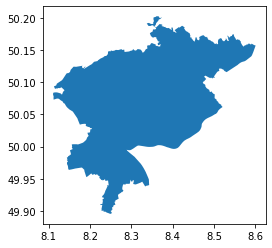

In [26]:
shape=read_shapefile('data/DEU_adm2.shp')
all_shapes=shape.cascade_union('NAME_2',['Mainz','Wiesbaden','Main-Taunus-Kreis'])
all_shapes.plot()


# Testing Functions:

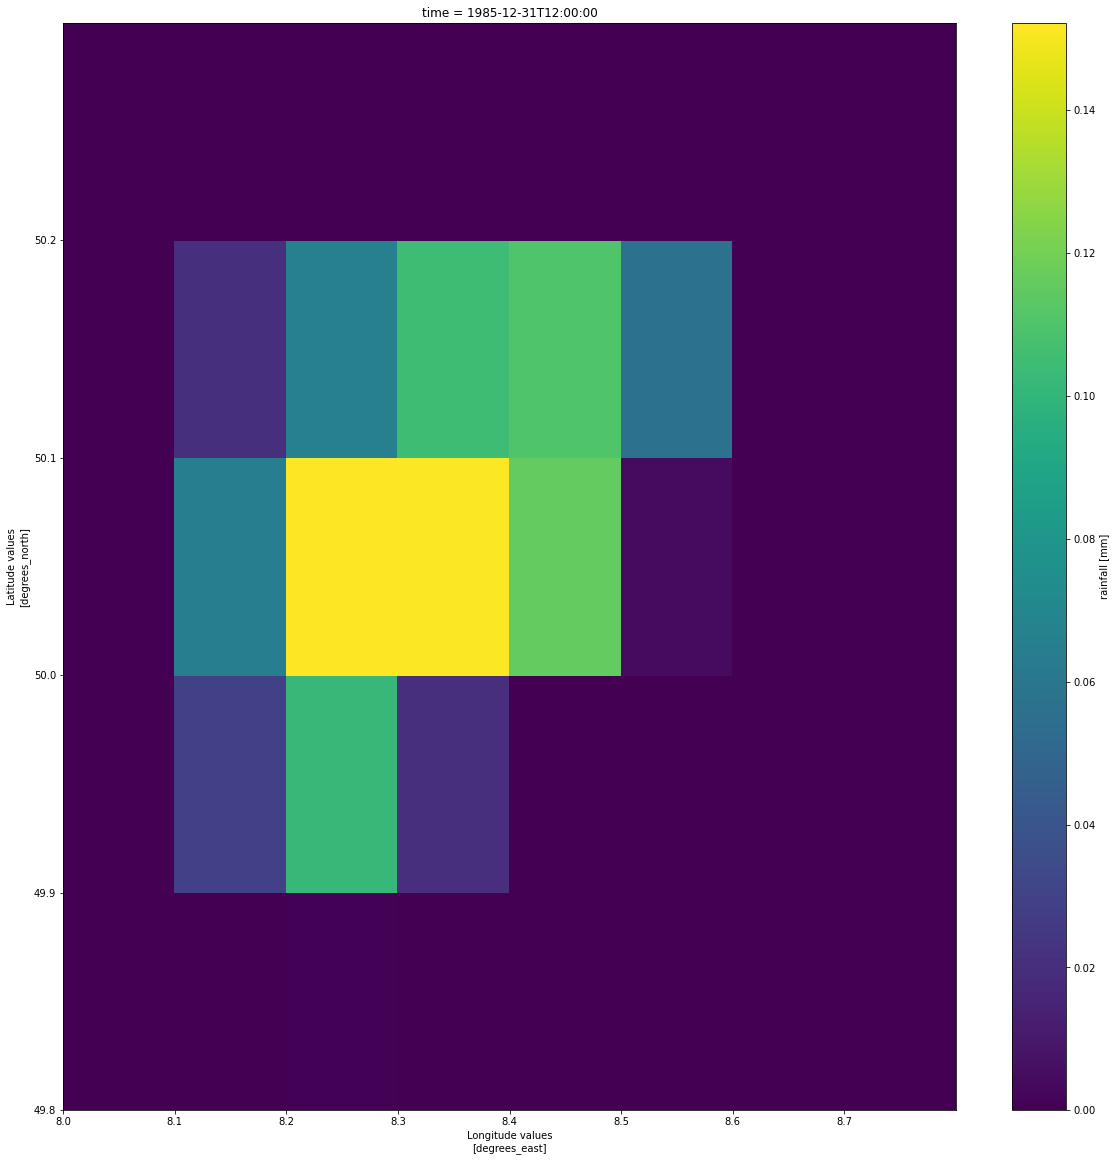

In [21]:
infile='data/Region_Wiesbaden_3LK_SBK_weights_EOBS_V19_0e_precmean_1971_2000.nc'
ds1 = xr.open_dataset(infile)
ds1=ds1.rename({'longitude': 'lon','latitude': 'lat'})
plt.figure(figsize=(20,20))
ds1['weights'][0,248:253, 330:338].plot()
plt.show()

<Figure size 720x720 with 0 Axes>

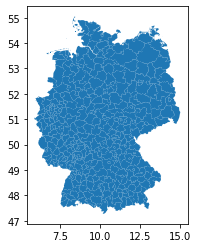

In [14]:
shapefile_tot = 'data/DEU_adm2.shp'
poly = gpd.read_file(shapefile_tot)
plt.figure(figsize=(10,10))
poly.plot()
plt.show()

<AxesSubplot:>

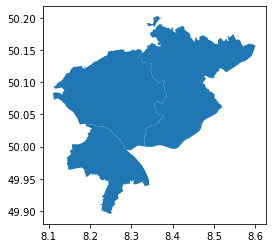

In [19]:
mainz=poly[poly['NAME_2'] == 'Mainz']
main_taunus=poly[poly['NAME_2'] == 'Main-Taunus-Kreis']
wiesbaden=poly[poly['NAME_2'] == 'Wiesbaden']
x=wiesbaden.append(mainz)
y=x.append(mainz_taunus)
y.plot()

In [22]:
geodataframe=[mainz,main_taunus,wiesbaden]
import regionmask
weighted_hannover= regionmask.mask_geopandas(geodataframe, ds1.weights[0,240:260,320:340].lon, ds1.weights[0,240:260,320:340].lat,method='weights_default')

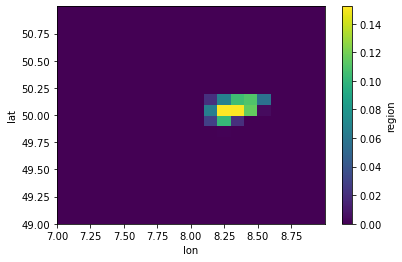

In [23]:
weighted_hannover.plot()

## With Susannes:

In [27]:

cyl=susanne(all_shapes.geometry.iloc[0],ds1['lat'][240:260],ds1['lon'][320:340],'cyl')
cea=susanne(all_shapes.geometry.iloc[0],ds1['lat'][240:260],ds1['lon'][320:340],'cea')
aeqd=susanne(all_shapes.geometry.iloc[0],ds1['lat'][240:260],ds1['lon'][320:340],'aeqd')

<ipython-input-28-ab7e48d4084b>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon,lat,cyl)
<ipython-input-28-ab7e48d4084b>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon,lat,cea)
<ipython-input-28-ab7e48d4084b>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'neare

Text(0.5, 1.0, 'original')

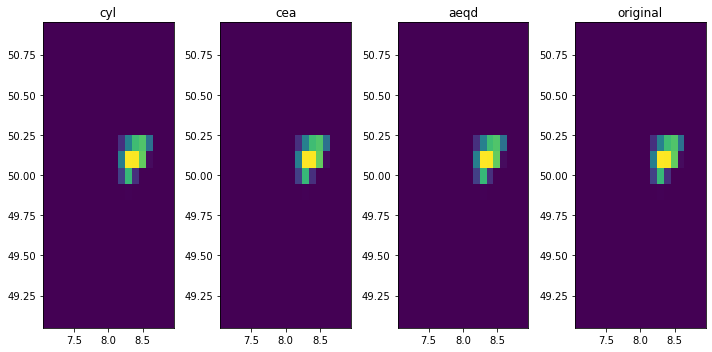

In [28]:
plt.figure(figsize=(10,5),tight_layout=True)

lat = np.squeeze(ds1['lat'][240:260])
lon = np.squeeze(ds1['lon'][320:340])

ax=plt.subplot(1,4,1)
plt.pcolormesh(lon,lat,cyl)
plt.title('cyl')

ax1 = plt.subplot(1,4,2)

plt.pcolormesh(lon,lat,cea)
plt.title('cea')

ax1 = plt.subplot(1,4,3)
plt.pcolormesh(lon,lat,aeqd)
plt.title('aeqd')

ax1 = plt.subplot(1,4,4)
plt.pcolormesh(lon,lat,ds1.weights[0,240:260,320:340])
plt.title('original')

<ipython-input-29-36ec8a5996fa>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1=plt.pcolormesh(lon,lat,delta(cyl), cmap=cmap)#,norm=norm)
<ipython-input-29-36ec8a5996fa>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2=plt.pcolormesh(lon,lat,delta(cea), cmap=cmap)#,norm=norm)
<ipython-input-29-36ec8a5996fa>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corne

Text(0.5, 1.0, 'aeqd Error')

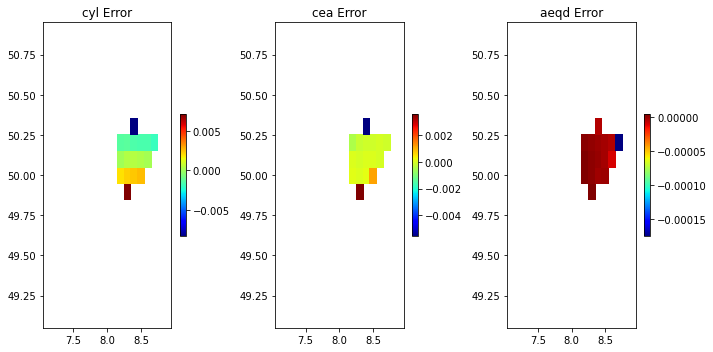

In [29]:
# Difference between my solution and the example
def delta(result):
    delta=(ds1.weights[0,240:260,320:340]-result)/ds1.weights[0,240:260,320:340]
    return(delta)



plt.figure(figsize=(10,5),tight_layout=True)

ax1=plt.subplot(1,3,1)
from matplotlib.colors import BoundaryNorm
cmap = plt.get_cmap('jet')
im1=plt.pcolormesh(lon,lat,delta(cyl), cmap=cmap)#,norm=norm)
plt.colorbar(im1,ax=ax1,shrink=0.4)
plt.title('cyl Error')

ax2=plt.subplot(1,3,2)
cmap = plt.get_cmap('jet')
im2=plt.pcolormesh(lon,lat,delta(cea), cmap=cmap)#,norm=norm)
plt.colorbar(im2,ax=ax2,shrink=0.4)
plt.title('cea Error')
           
ax3=plt.subplot(1,3,3)
cmap = plt.get_cmap('jet')
im3=plt.pcolormesh(lon,lat,delta(aeqd), cmap=cmap)#,norm=norm)
plt.colorbar(im3,ax=ax3,shrink=0.4)
plt.title('aeqd Error')

## My solution

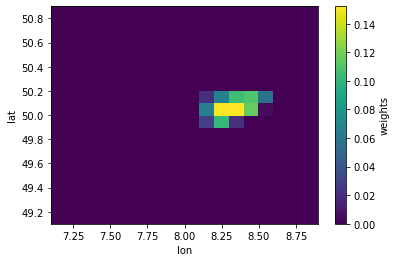

In [31]:
mysolution=Default(ds1.weights[0,240:260,320:340],all_shapes).areal_weights()
mysolution.plot()

In [32]:
#rw_cdf(path,grid_file,variable0,variable)

rw_cdf_susanne('data/','Region_Wiesbaden_3LK_SBK_weights_EOBS_V19_0e_precmean_1971_2000.nc',"weights",("weights2",cyl))

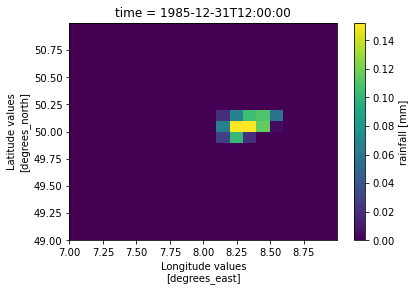

In [33]:
xr.open_dataset("data/susanne_rw_Region_Wiesbaden_3LK_SBK_weights_EOBS_V19_0e_precmean_1971_2000.nc").weights[0,240:260,320:340].plot()

# Solution with REGIONMASK

In [41]:
import regionmask


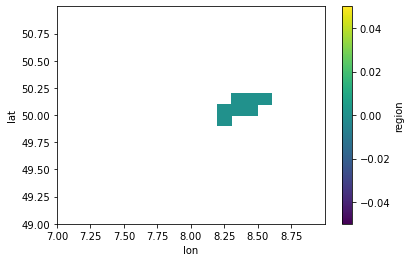

In [50]:
mainz=poly[poly['NAME_2'] == 'Mainz']
main_taunus=poly[poly['NAME_2'] == 'Main-Taunus-Kreis']
wiesbaden=poly[poly['NAME_2'] == 'Wiesbaden']
geodataframe=[mainz,main_taunus,wiesbaden]

weighted_hannover= regionmask.mask_geopandas(geodataframe, ds1.weights[0,240:260,320:340].lon, ds1.weights[0,240:260,320:340].lat)
weighted_hannover.plot()

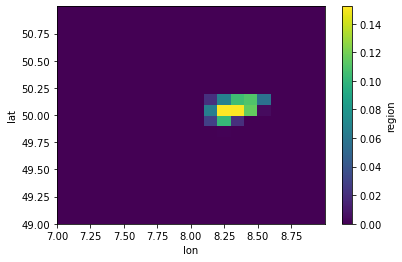

In [51]:
weighted_hannover= regionmask.mask_geopandas(geodataframe, ds1.weights[0,240:260,320:340].lon, ds1.weights[0,240:260,320:340].lat, method="weights_default")

weighted_hannover.plot()


# Rot.Pole Example

<Figure size 720x720 with 0 Axes>

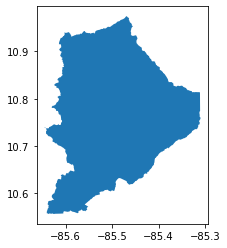

In [52]:
shapefile_tot = 'data_rot/Tempisque_cuenca_new.geojson'
poly = gpd.read_file(shapefile_tot)
plt.figure(figsize=(10,10))
poly.plot()
plt.show()

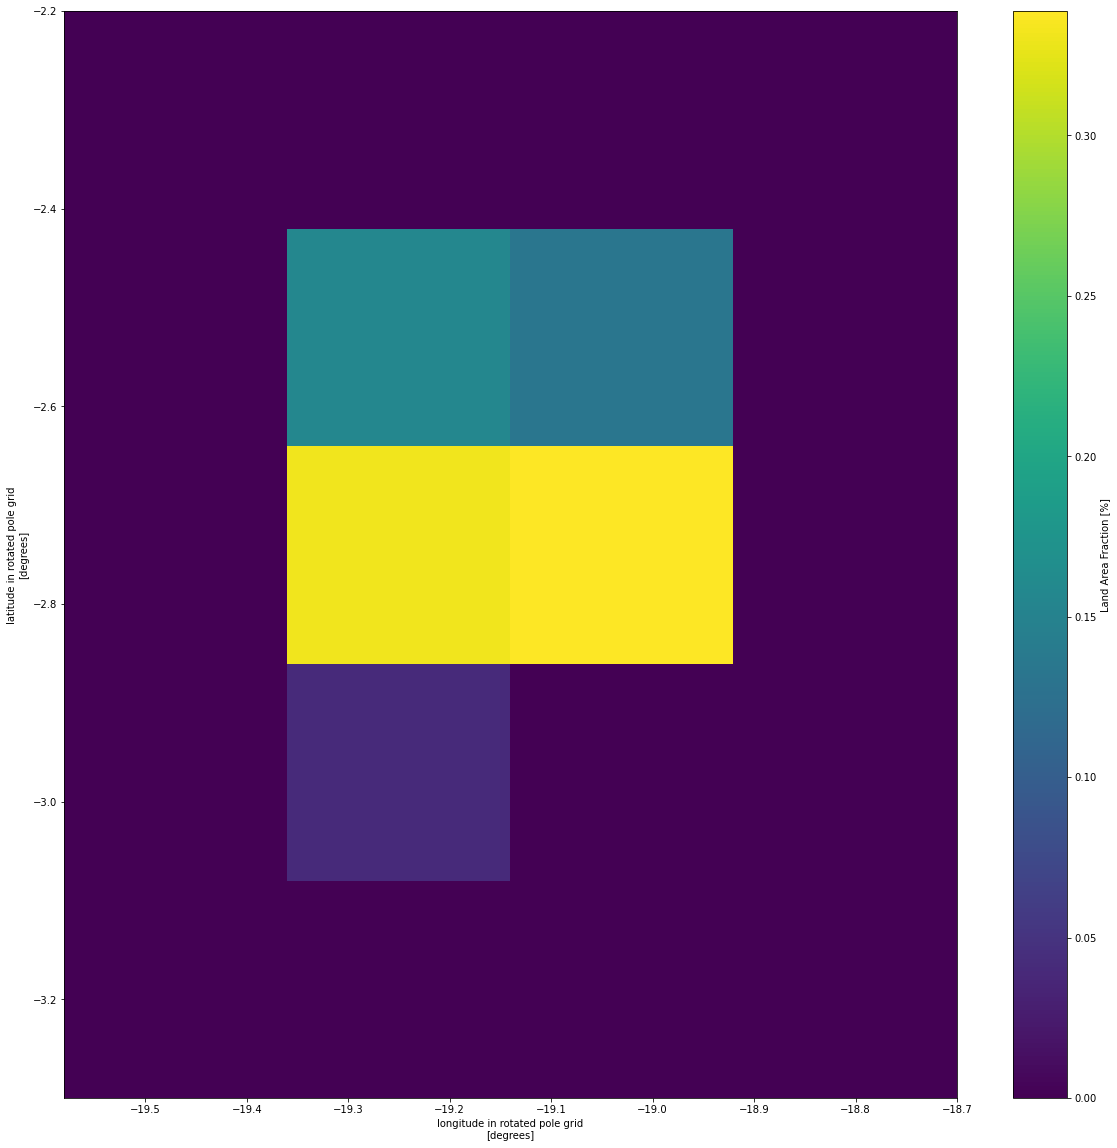

In [53]:
infile='data_rot/Tempisque_cuenca_SBK_weights_CORDEX_CORE_CAM022_REMO.nc'
ds1 = xr.open_dataset(infile)
plt.figure(figsize=(20,20))
ds1['weights'][116:121,151:155].plot()
plt.show()

In [55]:
proj_string= '+proj=ob_tran +o_proj=longlat +o_lon_p=0.0 +o_lat_p=75.74 +lon_0=293.98 +to_meter=0.017453292519943295 +ellps=WGS84'

In [56]:
weighted_hannover= regionmask.mask_geopandas(poly, ds1.weights[114:124,148:158].rlon, ds1.weights[114:124,148:158].rlat, method="weights_rot_pole")




Enter rotated pole projection in the form: +proj=ob_tran +o_proj=longlat +o_lon_p=... +o_lat_p=... +lon_0=... +to_meter=... +ellps=...: +proj=ob_tran +o_proj=longlat +o_lon_p=0.0 +o_lat_p=75.74 +lon_0=293.98 +to_meter=0.017453292519943295 +ellps=WGS84


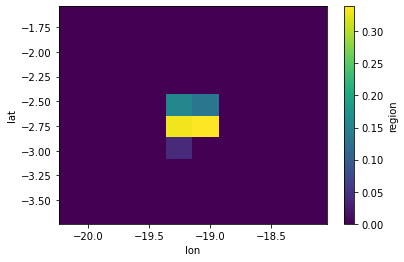

In [57]:
weighted_hannover.plot()